In [471]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import time

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

Load Data
---

In [2]:
header_row = ['label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

start_load_time = time.time()
data = pd.read_csv('../data/kaggle-display-advertising-challenge-dataset/train.txt', sep='\t', names=header_row, nrows=3000000)
print("Loading Time:",time.time()-start_load_time)

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)
target = ['label']

 # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
#mms = MinMaxScaler(feature_range=(0, 1),copy=False)
#data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

print("Shape:",data.shape)

pd.set_option('display.max_columns', len(data))
data

Loading Time: 17.714087963104248
Shape: (3000000, 40)


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,0.0,2.0,604,268,848553,132728,43,7,10058,79,2,29947,3564,158090,474,4,5888,285899,9,4253,249,3,19417,0,3,57441,69,30715
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,0.0,4.0,604,514,375982,70110,43,18,6686,23,2,7715,1540,278311,2629,17,9756,418883,0,3043,249,1,243203,0,3,19648,69,23237
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,219,25,9426,208134,43,7,9042,23,2,10480,1858,407308,2102,2,4660,112485,6,876,0,0,575361,11,3,17088,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,604,96,572327,49409,43,18,2155,23,2,42827,4544,461549,656,2,1003,172219,1,1995,0,0,268935,0,3,41965,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,785,381,675033,267410,43,2,7919,23,2,14642,4560,290726,2935,4,6063,3466,1,659,0,0,84436,0,2,51947,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1,1.0,888,0.0,0.0,503.0,35.0,8.0,1.0,2.0,1.0,3.0,0.0,0.0,527,123,435525,143822,106,7,7062,216,2,8262,3672,197215,2931,9,833,531960,0,792,0,0,326506,0,2,5344,0,0
2999996,1,0.0,-1,0.0,0.0,2556.0,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,30,325,149572,143037,106,9,4974,23,2,4609,1873,703940,904,4,5423,225248,9,730,0,0,65868,10,8,41860,0,0
2999997,1,0.0,-1,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,268,678675,119601,43,18,6818,23,0,10480,2263,492343,2715,17,2182,349245,5,3840,249,3,237220,0,11,6767,69,23797
2999998,0,0.0,6,0.0,0.0,40271.0,0.0,0.0,22.0,10.0,0.0,0.0,0.0,0.0,30,20,490018,263330,43,7,4792,397,2,10480,2093,492789,290,2,2809,389375,9,1812,0,0,10497,0,5,55990,0,0


Pre-process features for Pure Brute Force Method
---

In [583]:
a = pd.DataFrame(np.asarray([1,2,3,4]).reshape(1,-1))
features = []
for i in a:
    features.append(str(i))
a.columns = features
a = a.drop(columns=a[features[4:]])
a

,0,1,2,3
0,1,2,3,4


In [584]:
trunc_data = data.copy()

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

n_int_feats = 13
trunc_data = trunc_data.drop(columns=dense_features[n_int_feats:])
trunc_data = trunc_data.drop(columns=sparse_features[1:])
trunc_data['C1'] = pd.DataFrame(np.array(['' for _ in range(len(trunc_data['C1']))]))

dense_features = ['I'+str(i) for i in range(1, n_int_feats)] #I 1-5
sparse_features = ['C' + str(i) for i in range(1, 2)]


trunc_data[sparse_features] = trunc_data[sparse_features].fillna('-1', )
trunc_data[dense_features] = trunc_data[dense_features].fillna(0,)
target = ['label']

 # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    trunc_data[feat] = lbe.fit_transform(trunc_data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
trunc_data[dense_features] = mms.fit_transform(trunc_data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=trunc_data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

print("Shape:",trunc_data.shape)

pd.set_option('display.max_columns', len(trunc_data))
trunc_data

Shape: (3000000, 15)


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1
0,0,0.000827,0.000216,0.000076,0.000000,5.442957e-04,0.000017,0.000570,0.000395,0.009365,0.125,0.012903,0.000000,2.0,0
1,0,0.001654,0.000162,0.000671,0.001783,4.017233e-05,0.000034,0.000076,0.000395,0.000207,0.125,0.006452,0.000000,4.0,0
2,0,0.001654,0.000162,0.000015,0.024955,3.020802e-04,0.000381,0.000152,0.000395,0.012677,0.125,0.019355,0.002333,45.0,0
3,0,0.000000,0.048367,0.000000,0.000000,1.729773e-03,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0
4,0,0.002481,0.000108,0.000000,0.000000,7.876928e-07,0.000000,0.000114,0.000000,0.000000,0.125,0.006452,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1,0.000827,0.048097,0.000000,0.000000,1.981047e-04,0.000150,0.000304,0.000197,0.000103,0.125,0.019355,0.000000,0.0,0
2999996,1,0.000000,0.000108,0.000000,0.000000,1.006671e-03,0.000000,0.000761,0.000000,0.000000,0.000,0.006452,0.000000,0.0,0
2999997,1,0.000000,0.000108,0.000000,0.000000,3.938464e-06,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0
2999998,0,0.000000,0.000486,0.000000,0.000000,1.586059e-02,0.000000,0.000000,0.004344,0.000517,0.000,0.000000,0.000000,0.0,0


Generate the training samples and train the model
---

In [585]:
#Last parameter of model is 0 is reflect null categorical feature

train, test = train_test_split(trunc_data, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [586]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=1, validation_split=0.2, )

Epoch 1/10
7500/7500 [==============================] - 23s 3ms/step - loss: 0.5234 - binary_crossentropy: 0.5234 - val_loss: 0.5164 - val_binary_crossentropy: 0.5164
Epoch 2/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5153 - binary_crossentropy: 0.5153 - val_loss: 0.5160 - val_binary_crossentropy: 0.5160
Epoch 3/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5142 - binary_crossentropy: 0.5142 - val_loss: 0.5152 - val_binary_crossentropy: 0.5152
Epoch 4/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5136 - binary_crossentropy: 0.5136 - val_loss: 0.5132 - val_binary_crossentropy: 0.5132
Epoch 5/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.5129 - binary_crossentropy: 0.5129 - val_loss: 0.5132 - val_binary_crossentropy: 0.5132
Epoch 6/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5119 - binary_crossentropy: 0.5119 - val_loss: 0.5139 - val_binary_crossentropy: 0.513

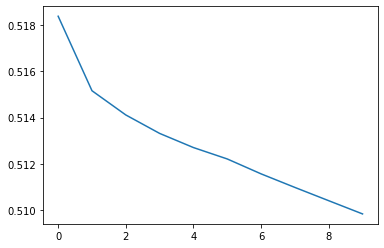

In [587]:
plt.plot(history.history['loss'])

In [588]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test MSE 0.1685
test LogLoss inf


/Users/sean/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


test AUC 0.712


In [589]:
eval_result = model.evaluate(test_model_input)
print(eval_result)

18750/18750 [==============================] - 37s 2ms/step - loss: 1.6973e-06 - binary_crossentropy: 0.0000e+00
[1.6973332321867929e-06, 0.0]


In [590]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

for sample_i in range(len(pred_ans)):
    if round(pred_ans[sample_i][0]) == test.label.iloc[sample_i]: # Predicted == Actual
        if test.label.iloc[sample_i] == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if test.label.iloc[sample_i] == 1:
            false_neg += 1
        else:
            false_pos += 1

accuracy = (true_pos + true_neg) / len(pred_ans)
print("Accuracy:",accuracy)

Accuracy: 0.758115


In [591]:
confusion_matrix = [[true_pos, false_pos],[false_neg,true_neg]]
confusion_matrix

[[14573, 9418], [135713, 440296]]

In [201]:
#save_model(model, 'DeepFMint.h5')# save_model, same as before

In [4]:
model = load_model('../models/DeepFMint.h5',custom_objects)# load_model,just add a parameter

Calculate Training Data Distribution
---

In [210]:
start_load_time = time.time()
raw_data = pd.read_csv('../data/kaggle-display-advertising-challenge-dataset/train.txt', sep='\t', names=header_row, nrows=3000000)
print("Loading Time:",time.time()-start_load_time)
pd.set_option('display.max_columns', len(raw_data))

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

raw_data[sparse_features] = raw_data[sparse_features].fillna('-1', )
raw_data[dense_features] = raw_data[dense_features].fillna(0,)

raw_data

Loading Time: 18.5407657623291


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,0.0,2.0,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,-1,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,0.0,4.0,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,-1,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,287e684f,0a519c5c,02cf9876,c18be181,25c83c98,7e0ccccf,c78204a1,0b153874,a73ee510,3b08e48b,5f5e6091,8fe001f4,aa655a2f,07d13a8f,6dc710ed,36103458,8efede7f,3412118d,-1,-1,e587c466,ad3062eb,3a171ecb,3b183c5c,-1,-1
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68fd1e64,2c16a946,a9a87e68,2e17d6f6,25c83c98,fe6b92e5,2e8a689b,0b153874,a73ee510,efea433b,e51ddf94,a30567ca,3516f6e6,07d13a8f,18231224,52b8680f,1e88c74f,74ef3502,-1,-1,6b3a5ca6,-1,3a171ecb,9117a34a,-1,-1
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,8cf07265,ae46a29d,c81688bb,f922efad,25c83c98,13718bbd,ad9fa255,0b153874,a73ee510,5282c137,e5d8af57,66a76a26,f06c53ac,1adce6ef,8ff4b403,01adbab4,1e88c74f,26b3c7a7,-1,-1,21c9516a,-1,32c7478e,b34f3128,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1,1.0,888,0.0,0.0,503.0,35.0,8.0,1.0,2.0,1.0,3.0,0.0,0.0,5bfa8ab5,38a947a1,810887e7,8597e798,4cf72387,7e0ccccf,9ade2fc1,5b392875,a73ee510,2e940f79,b8deab54,457f88b5,efbb2435,64c94865,1435ee9f,ff6ee0d7,07c540c4,2ebcb279,-1,-1,82487d8f,-1,32c7478e,12d17b0e,-1,-1
2999996,1,0.0,-1,0.0,0.0,2556.0,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,05db9164,9adf4cf9,2c43536d,84f1c38f,4cf72387,c05778d5,6adafc58,0b153874,a73ee510,19b8ab6f,5fe1af6e,f8b55668,49642e3e,1adce6ef,808ff1bc,6c12a781,e5ba7672,2a93f7c8,-1,-1,1a5b248f,8ec974f4,93bad2c0,90b6276f,-1,-1
2999997,1,0.0,-1,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,05db9164,80e26c9b,c92acf96,6f0ed6cb,25c83c98,fe6b92e5,95b0fb8d,0b153874,7cc72ec2,3b08e48b,71fd20d9,adf02f65,ddd66ce1,b28479f6,337d8d28,a78f25f7,776ce399,dc593eab,21ddcdc9,b1252a9d,5e9baaea,-1,be7c41b4,1793a828,e8b83407,75cf7ffd
2999998,0,0.0,6,0.0,0.0,40271.0,0.0,0.0,22.0,10.0,0.0,0.0,0.0,0.0,05db9164,08d6d899,9143c832,f56b7dd5,25c83c98,7e0ccccf,66ea8ad1,a674580f,a73ee510,3b08e48b,69628afd,ae1bb660,17c1f5eb,07d13a8f,41f10449,bad5ee18,e5ba7672,698d1c68,-1,-1,0429f84b,-1,55dd3565,c0d61a5c,-1,-1


In [211]:
raw_data['label'].sum()/len(raw_data) #25% of data has 1s

0.2510406666666667

In [246]:
#Find positive recommendations???
pos = []
for el in range(len(raw_data)):
    if (raw_data['label'] == 1)[el] == True:
        pos.append(el)

KeyboardInterrupt: 

In [276]:
for p in pos:
    pos_rec = []
    for i in range(len(dense_features[:5])):
        pos_rec.append(raw_data[dense_features[i]][p])
    print(query_model(np.asarray(pos_rec)))

#Model is broken... every pos rec from training is showing negative

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

Initialize BFET and query rec
---

In [72]:
def construct_bfet(feat_range):
    dense_features = ['I1','I2','I3','I4','I5']
    ndims = len(dense_features)
    bfet_shape = (feat_range,) * ndims
    return np.ndarray(bfet_shape)

bfet = construct_bfet(10)
bfet.shape

(10, 10, 10, 10, 10)

BFS on BFET - Multi-way Feature Interactions
---

In [290]:
queryrec = np.asarray([1,888,0,0,503])
query_model(queryrec)

0

In [289]:
def find_adjs(node):
    
    adj_nodes = []
    for dim in range(len(node)):
        temp = node.copy()
        temp[dim] = temp[dim] + 1
        adj_nodes.append(temp)
        temp = node.copy()
        temp[dim] = temp[dim] - 1
        adj_nodes.append(temp)
    return adj_nodes


def query_model(node):
    
    transf_node = mms.transform([node])
    transf_node = np.append(transf_node,0)#Last parameter of model is 0 is reflect null categorical feature
    queryrec_input = {feature_names[name]:np.asarray([transf_node[name]]) for name in range(len(feature_names))}
    return int(model.predict(queryrec_input)) #returns model recommendation


def bfs(graph_shape, node):
    
    k = 8
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    
    frontier = deque() # create a queue for doing BFS
    
    visited = {} # True corresponds to visited for low complexity "visited" search
    visited[tuple(node)] = True #mark the source vertex as discovered
 
    frontier.append(node) # enqueue source rec
    
    source_rec = query_model(node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k:
 
        # dequeue front node
        node = frontier.popleft()
        #print(node, end=' ')
 
        adjs = find_adjs(node) #every node adjacent to the current node
        for adj_node in adjs:
            
            in_bfet = True
            for i in range(len(adj_node)):
                if adj_node[i] >= graph_shape[i] or adj_node[i] < 0:
                    in_bfet = False
            
            if in_bfet and tuple(adj_node) not in visited.keys():
                
                visited[tuple(adj_node)] = True
                frontier.append(adj_node)
                
                query_rec = query_model(adj_node)
                print(adj_node, ':',query_rec)
                if query_rec != source_rec:
                    discovered.append(adj_node)
                    print("^  SOLUTION!!!!!!!!!  ^")
    return discovered


#Model, feature_names are global
queryrec = np.asarray([5,5,5,5,5])
feature_names = ['I1','I2','I3','I4','I5','C1']
bfet_dims = 10
bfet_shape = np.repeat([bfet_dims],5)
#solutions = bfs(bfet_shape, queryrec)

In [113]:
print("Feature values leading to opposite rec : Distance of features from source features")
distance = {}
for soln in solutions:
    distance[tuple(soln)] = soln - queryrec

distance

Feature values leading to opposite rec : Distance of features from source features


{(0, 5, 5, 5, 5): array([-5,  0,  0,  0,  0]),
 (0, 6, 5, 5, 5): array([-5,  1,  0,  0,  0]),
 (0, 4, 5, 5, 5): array([-5, -1,  0,  0,  0]),
 (0, 5, 6, 5, 5): array([-5,  0,  1,  0,  0]),
 (0, 5, 4, 5, 5): array([-5,  0, -1,  0,  0]),
 (0, 5, 5, 6, 5): array([-5,  0,  0,  1,  0]),
 (0, 5, 5, 4, 5): array([-5,  0,  0, -1,  0]),
 (0, 5, 5, 5, 6): array([-5,  0,  0,  0,  1]),
 (0, 5, 5, 5, 4): array([-5,  0,  0,  0, -1])}

In [131]:
print("Feature Values      Total Distance")
for key in distance:
    print(key,end=' --> ')
    print(np.array(abs(distance[key])),end=': ')
    dsum = 0
    for feat in np.array(abs(distance[key])):
        dsum += feat ** 2
    linear_distance = round(math.sqrt(dsum),3)
    print("Linear:",linear_distance,end=' ')
    mdistance = np.array(abs(distance[key])).sum()
    print("Block:",mdistance)

Feature Values      Total Distance
(0, 5, 5, 5, 5) --> [5 0 0 0 0]: Linear: 5.0 Block: 5
(0, 6, 5, 5, 5) --> [5 1 0 0 0]: Linear: 5.099 Block: 6
(0, 4, 5, 5, 5) --> [5 1 0 0 0]: Linear: 5.099 Block: 6
(0, 5, 6, 5, 5) --> [5 0 1 0 0]: Linear: 5.099 Block: 6
(0, 5, 4, 5, 5) --> [5 0 1 0 0]: Linear: 5.099 Block: 6
(0, 5, 5, 6, 5) --> [5 0 0 1 0]: Linear: 5.099 Block: 6
(0, 5, 5, 4, 5) --> [5 0 0 1 0]: Linear: 5.099 Block: 6
(0, 5, 5, 5, 6) --> [5 0 0 0 1]: Linear: 5.099 Block: 6
(0, 5, 5, 5, 4) --> [5 0 0 0 1]: Linear: 5.099 Block: 6


Given this scenario where the k=8 closest solutions all contain the same distance for a single feature, with none of the recommendations existing independently of feat(0).val = 0. What is the best way to analyze this output? <br> 

It can be concluded that feat(0) is the most unstable feature for this recommendation, such that a small change to feat(0) had the largest impact on the model recommendation. This feature instability can be interpreted as explainability of the recommendation, as it provides insight into where the model would recommend differently.

DFS on BFET - 1-way Feature Interactions
---

In [92]:
def dfs(graph_shape,node):

    source_rec = query_model(node) #rec value to be explained
    discovered = []
    for feat in range(len(node)):
        
        start_search_time = time.time()
        found = False
        cur_node = node.copy()
        while cur_node[feat] < graph_shape[feat]-1 and not found:
            cur_node[feat] += 1
            rec = query_model(cur_node)
            print(rec,':',cur_node[feat])
            if rec != source_rec:
                discovered.append(cur_node)
                found = True
                print(cur_node, end=', ')
        print(feat,"Search Time <--:",time.time()-start_search_time)
        
        start_search_time = time.time()
        cur_node = node.copy()
        while cur_node[feat] > 0 and not found:
            cur_node[feat] -= 1
            rec = query_model(cur_node)
            print(rec,':',cur_node[feat])
            if rec != source_rec:
                discovered.append(cur_node)
                found = True
                print(cur_node, end=', ')
        print(feat,"Search Time -->:",time.time()-start_search_time)
    return discovered


queryrec = np.asarray([0,0,0,0,0])
#bfet = construct_bfet(100)
bfet_dims = 100
bfet_shape = np.repeat([bfet_dims],5)
solutions = dfs(bfet_shape,queryrec)
solutions

0 : 1
0 : 2
0 : 3
0 : 4
0 : 5
0 : 6
0 : 7
0 : 8
0 : 9
0 : 10
0 : 11
0 : 12
0 : 13
0 : 14
0 : 15
0 : 16
0 : 17
0 : 18
0 : 19
0 : 20
0 : 21
0 : 22
0 : 23
0 : 24
0 : 25
0 : 26
0 : 27
0 : 28
0 : 29
0 : 30
0 : 31
0 : 32
0 : 33
0 : 34
0 : 35
0 : 36
0 : 37
0 : 38
0 : 39
0 : 40
0 : 41
0 : 42
0 : 43
0 : 44
0 : 45
0 : 46
0 : 47
0 : 48
0 : 49
0 : 50
0 : 51
0 : 52
0 : 53
0 : 54
0 : 55
0 : 56
0 : 57
0 : 58
0 : 59
0 : 60
0 : 61
0 : 62
0 : 63
0 : 64
0 : 65
0 : 66
0 : 67
0 : 68
0 : 69
0 : 70
0 : 71
0 : 72
0 : 73
0 : 74
0 : 75
0 : 76
0 : 77
0 : 78
0 : 79
0 : 80
0 : 81
0 : 82
0 : 83
0 : 84
0 : 85
0 : 86
0 : 87
0 : 88
0 : 89
0 : 90
0 : 91
0 : 92
0 : 93
0 : 94
0 : 95
0 : 96
0 : 97
0 : 98
0 : 99
0 Search Time <--: 5.156486749649048
0 Search Time -->: 6.9141387939453125e-06
0 : 1
0 : 2
0 : 3
0 : 4
0 : 5
0 : 6
0 : 7
0 : 8
0 : 9
0 : 10
0 : 11
0 : 12
0 : 13
0 : 14
0 : 15
0 : 16
0 : 17
0 : 18
0 : 19
0 : 20
0 : 21
0 : 22
0 : 23
0 : 24
0 : 25
0 : 26
0 : 27
0 : 28
0 : 29
0 : 30
0 : 31
0 : 32
0 : 33
0 : 34
0 : 35
0

[]

Gradient Descent Feature Explainability & Stability Tensor Search (GDFEST Search)
---
BFS to identify decision boundary, A* to perform gradient descent along decision boundary

Construct Model Classifying Debuggable Decision Boundary
---

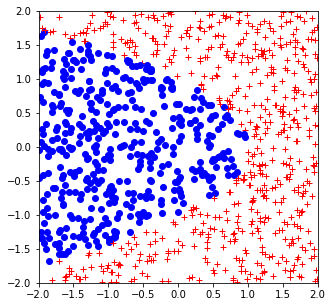

In [384]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.ylim(-2,2)
plt.xlim(-2,2)

nfeats = 2
v = []
labels = []
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-2, high=2, size=(nfeats,))
    v.append(point)
    if (point[0]**1) + (point[1]**2) < 1:
        labels.append(1)
        plt.plot(point[0],point[1],'bo')
    else:
        labels.append(0)
        plt.plot(point[0],point[1],'r+')

In [406]:
train_ds = np.asarray(v)
train_labels = np.asarray(labels)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(train_ds, train_labels, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 0.6892 - accuracy: 0.7204 - precision: 0.7386 - recall: 0.6300
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9218 - precision: 0.9315 - recall: 0.8918
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1199 - accuracy: 0.9517 - precision: 0.9551 - recall: 0.9338
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.9532 - precision: 0.9460 - recall: 0.9504
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9498 - precision: 0.9462 - recall: 0.9418
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9566 - precision: 0.9812 - recall: 0.9172
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9711 - precision: 0.9789 - recall: 0.9528
Epoch 8/100
32/32 [=============================

32/32 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9805 - precision: 0.9846 - recall: 0.9680
Epoch 61/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9815 - precision: 0.9816 - recall: 0.9763
Epoch 62/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9786 - precision: 0.9782 - recall: 0.9736
Epoch 63/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9706 - precision: 0.9867 - recall: 0.9424
Epoch 64/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9918 - precision: 0.9942 - recall: 0.9865
Epoch 65/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9827 - precision: 0.9848 - recall: 0.9743
Epoch 66/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9684 - precision: 0.9726 - recall: 0.9543
Epoch 67/100
32/32 [==============================] - 

In [405]:
def query_simple_model(node):
    query = node.reshape(1, -1)
    pred = round(model.predict(query)[0,0])
    return pred

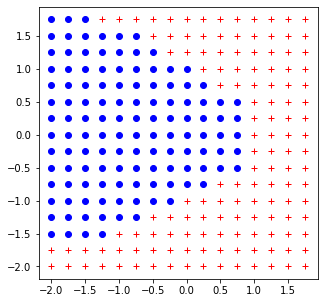

In [407]:
#Every prediction made by model
fig, ax = plt.subplots(figsize = (5, 5))
steps = np.arange(-2,2,0.25)
for i in steps:
    for j in steps:
        pred = query_simple_model(np.asarray([i,j]))
        if pred == 1:
            plt.plot(i,j,'bo')
        else:
            plt.plot(i,j,'r+')

Generate random vectors from source node and use to find k point-distance heuristics to perform informed search from toward source
----

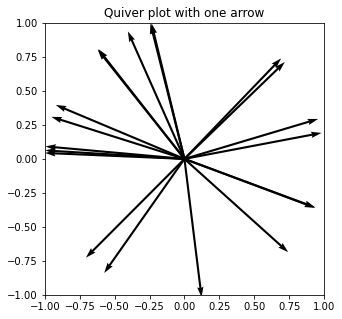

In [456]:
def generate_unit_vectors(nfeats,nvectors):
    
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        v_hat = v / np.linalg.norm(v)
        vectors.append(v_hat)
    return vectors

vectors = generate_unit_vectors(2,20)
 
# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))
for v in vectors:
    ax.quiver(0, 0, v[0],v[1],scale=2)
ax.set_title('Quiver plot with one arrow')
 
# Show plot
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

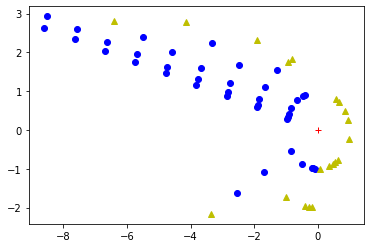

In [482]:
# sum(block distance) would be more efficent at scale, avoiding sqrt and squares
#returns distance for ndim feature space
def get_distance(source_node,query_node):
    dif = query_node - source_node
    dsum = 0
    for feat in dif:
        dsum += feat**2
    return math.sqrt(dsum)


def generate_precursor_solutions(source_node,k=20,nsteps=6,plot_search=False,max_distance=10):

    max_distance = 10 #use training set statistics to determine
    step_size = int(max_distance/nsteps)
    steps = np.arange(step_size,max_distance,step_size)
    source_rec = query_simple_model(source_node)
    
    if plot_search:
        plt.plot(source_feats[0],source_feats[1],'r+')

    discovered = {}

    while len(discovered) < k:
        unit_vector = generate_unit_vectors(len(source_node),1)[0]
        for step in steps:
            scaled_vector = np.asarray(unit_vector * step + source_node)
            query_rec = query_simple_model(scaled_vector)
            
            if plot_search:
                if query_rec == source_rec:
                    plt.plot(scaled_vector[0],scaled_vector[1],'bo')
                else:
                    plt.plot(scaled_vector[0],scaled_vector[1],'y^')
            
            if source_rec != query_rec:

                discovered[tuple(scaled_vector)] = get_distance(source_node,scaled_vector) # distance heuristic
                break
    
    return discovered
                
source_node = np.asarray([0,0])
max_distance = 10
prelim_discovered = generate_precursor_solutions(source_node,plot_search=True,max_distance=max_distance)

Blue dots indicate points in uniform vectors from the source recommendation that have not yet resulted in a model.predict() of the opposite value of the source node's prediction, while yellow triangles indicate the position resulting in an opposite prediction than the source node.

A* Search from k discovered uniformly distributed solutions
----

In [470]:
class Node:
    def __init__(self, position, f_cost):
        
        #Position list([row, column])
        self.position = list(position) # [n1, n2, ..., n|N|]
        self.f_cost = f_cost #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same f_cost
    def __eq__(self, other):
        return isinstance(other, Node) and self.f_cost == other.f_cost
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.f_cost < other.f_cost

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.f_cost > other.f_cost

In [558]:
#TODO: Adapative gradient to make largest jumps in k-closest solutions first
def find_priority_adjs(node,learning_rate=0.1):
    
    adj_nodes = []
    for dim in range(len(node)):
        temp = node.copy()
        temp[dim] = temp[dim] + learning_rate
        adj_nodes.append(temp)
        temp = node.copy()
        temp[dim] = temp[dim] - learning_rate
        adj_nodes.append(temp)
    return adj_nodes


def a_star_search(source_node, prelim_discovered, max_distance,k=100,learning_rate=0.1):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    visited = {} # True corresponds to visited for low complexity "visited" search
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for position in prelim_discovered:
        cur = Node(position, prelim_discovered[position]) #(Node.position, Node.f_cost)
        heapq.heappush(frontier, cur)
        nodes_generated += 1
    
    source_rec = query_simple_model(source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    #TODO: Want to define stop criteria based on no solutions approaching center
    while frontier and len(discovered) < k:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check goal state
        query_rec = query_simple_model(np.asarray(query_node.position))
        if query_rec != source_rec:
            discovered.append(query_node)
            heapq.heappush(discovered, query_node) #priority queue so discovered is sorted by feature importance
            print("soln:",query_node.position)
 
        #TODO: Want to add these to priority queue before visiting them
        adjs = find_priority_adjs(query_node.position,learning_rate) #every node adjacent to the current node
        for adj_node in adjs:
            
            in_bfet = True
            for i in range(len(adj_node)):
                if adj_node[i] >= max_distance or adj_node[i] <= -1*max_distance:
                    in_bfet = False
            
            if in_bfet and tuple(adj_node) not in visited.keys():
                
                cur_adj = Node(adj_node, get_distance(source_node,adj_node))
                heapq.heappush(frontier, cur_adj)
                visited[tuple(adj_node)] = True
                nodes_generated += 1
    
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)
    print("Visited Length:",len(visited))

    return discovered

soln: [-4.171768865617628, 2.7561466818483034]
soln: [-3.6717688656176284, 2.7561466818483034]
soln: [-3.1717688656176284, 2.7561466818483034]
soln: [-2.6717688656176284, 2.7561466818483034]
soln: [-2.6717688656176284, 2.2561466818483034]
soln: [-2.1717688656176284, 2.2561466818483034]
soln: [0.8282311343823716, -0.7438533181516966]
soln: [0.8282311343823716, 0.7561466818483034]
soln: [-0.17176886561762839, -1.2438533181516966]
soln: [-0.17176886561762839, 1.2561466818483034]
soln: [0.3282311343823716, -1.2438533181516966]
soln: [0.3282311343823716, 1.2561466818483034]
soln: [1.3282311343823716, -0.24385331815169664]
soln: [1.3282311343823716, 0.25614668184830336]
soln: [0.8282311343823716, -1.2438533181516966]
Nodes Visited: 39
Nodes Generated: 71
Visited Length: 70


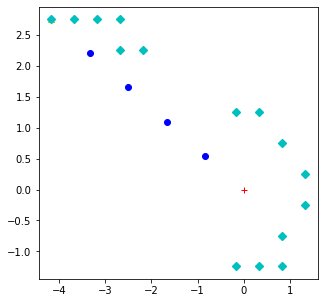

In [559]:
np.random.seed(7)
source_node = np.asarray([0,0])
max_distance = 10
fig, ax = plt.subplots(figsize = (5, 5))

prelim_discovered = generate_precursor_solutions(source_node,k=1,plot_search=True,max_distance=max_distance)
discovered = a_star_search(source_node, prelim_discovered, max_distance,k=30,learning_rate=0.5)

for point in discovered:
    plt.plot(point.position[0],point.position[1],'cD')

0.88825174259723
0.8935221567092808
0.88825174259723
0.8987592192031232
0.8936749283917622
0.8936749283917622
0.8987592192031232
0.899802712431546
0.9085019821248473
0.8987592192031232
0.9051670778469634
0.9051670778469634
0.8979925776077893
0.9033756579570545
0.9047396859958783
0.9432198680101078
0.8998027124315461
0.9131398905795587
0.8987592192031232
0.9165699619064256
0.9379866498126618
0.9390294530112173
0.9480491688790518
0.9560671894978823
0.9588938860746097
0.9588938860746097
0.9033756579570544
0.9058133702494597
0.9047396859958782
0.9432198680101078
0.9085019821248472
0.9745785800918622
0.9660359619166138
0.9239162620945481
0.9130582418557428
0.9131398905795588
0.9240500834524551
0.9520514959645644
0.9095336153456233
0.9245534275919378
0.9302698262688587
0.9390294530112173
0.9390294530112173
0.9490142427601278
0.9390294530112173
0.9588192873223984
0.9480491688790519
0.9588192873223984
0.9560671894978824
0.9646061024750721
0.9646061024750721
0.9646061024750721
0.903375657957054

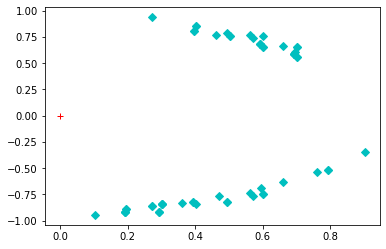

In [522]:
plt.plot(source_feats[0],source_feats[1],'r+')
for point in discovered[:60]:
    print(point.f_cost)
    plt.plot(point.position[0],point.position[1],'cD')

Constraints
-

TODO: 
-Model predicts negative most of the time, likely due to lack of important catgorical features --> use embedding vectors
-access embedding vectors from DeepFM to use in GDFEST
-project embedding vectors to m dimensional space
-create model to convert categorical features from one hot encoding to embedding vector so that it can be searched in continuous space, then when the step is made project the embedding vector back to one hot encoding so that deepFM can query a predicition with it (for a given feature, a step will push a category to an adjacent category further away from the source node category)
-find the distribution of each feature from the training data + embeddings to be able to make even steps in each feature direction to preserve the relative step distance, by using the range from min to max distance
-add implications section to paper about how explainability can be used, i.e. query explainability on every training data point that was incorrect, then generate synthetic data to push the decision boundary in feature space toward the correct rec/prediction

Its likely that most integer features in recommendation systems will not be continous in space (user id, item_id, occupation) <br>

Continuous/low dim features: release_date, age, height, weight, gender, location (x,y), rating, timestamp <br>

Must normalize step size for each feature/dimension, such that the step in one dimension changes the value of another dimension by an equal magnitude in terms of the maximum number of values available to each respective dimension